# Day7 Seq2Seq with AA


## Encoder with AA

### Applications
- Input: AA, Output: GO
- Input: AA, Output: Secondary structure (Alpha helix H, Beta sheet E, Coil C)
- Input: AA, Output: AA (mutant)
- Input: AA, Output: AA (input AA)
- etc

#### Training

![](images/seq2seq_aa_training.png)

#### Testing

![](images/seq2seq_aa_testing.png)

### Data generation (simulation)

- Random generation of amino acid sequences for source corpus (data)
- Transform the source corpus to target corpus with following rules
  - A --> T
  - R --> N
  - N --> R
  - D --> C
  - C --> D

- This seems not a good example for Seq2Seq since random sampling of the source AA sequences produces no sequencial (time-course) information which can be captured by the RNN models  


In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, source_sequences, target_sequences):
        self.source_sequences = source_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.source_sequences)

    def __getitem__(self, idx):
        return self.source_sequences[idx], self.target_sequences[idx]

# Example amino acids
amino_acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

# Generate source sequences
num_sequences = 100 # number of samples
sequence_length = 10 
source_sequences = [
    "".join(np.random.choice(amino_acids, size=sequence_length)) for _ in range(num_sequences)
]

# Transformation pattern for generating target sequences
def transform_to_target(sequence):
    # Example pattern: Reverse the sequence and replace specific amino acids
    mapping = {"A": "T", "R": "N", "N": "R", "D": "C", "C": "D"}  # Custom substitution rules
    transformed = [mapping.get(aa, aa) for aa in sequence]  # substitution
    return "".join(transformed)

# Create target sequences based on the pattern
target_sequences = [transform_to_target(seq) for seq in source_sequences]

# Build vocabulary
vocab = {aa: idx for idx, aa in enumerate(amino_acids)}
# include padding token, <pad>, start token <sos> and end token <eos>
vocab["<pad>"] = len(vocab)
vocab["<sos>"] = len(vocab)
vocab["<eos>"] = len(vocab)
vocab_size = len(vocab)

# Build idx2vocab
idx2vocab = {idx: aa for aa, idx in vocab.items()}

# Encode sequences into integer indices
def encode_sequence(sequence, vocab):
    return [vocab[aa] for aa in sequence]

encoded_source_sequences = [encode_sequence(seq, vocab) for seq in source_sequences]
encoded_target_sequences = [encode_sequence(seq, vocab) for seq in target_sequences]

# Collate function for padding
# The collate_batch function handles these differences by padding shorter sequences so that 
# all sequences in a batch have the same length.
def collate_batch(batch, vocab_size):
    source_batch, target_batch = zip(*batch)
    source_lengths = [len(seq) for seq in source_batch]
    target_lengths = [len(seq) for seq in target_batch]

    # Pad sequences
    max_src_len = max(source_lengths)
    max_tgt_len = max(target_lengths)
    padded_src = torch.zeros(len(source_batch), max_src_len, dtype=torch.long)
    padded_tgt = torch.zeros(len(target_batch), max_tgt_len, dtype=torch.long)

    for i, seq in enumerate(source_batch):
        padded_src[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)
    for i, seq in enumerate(target_batch):
        padded_tgt[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)

    return padded_src, source_lengths, padded_tgt, target_lengths

# Create dataset and dataloader
# separate training and test data
from sklearn.model_selection import train_test_split
train_source, test_source, train_target, test_target = train_test_split(encoded_source_sequences, encoded_target_sequences, test_size=0.2)

train_dataset = Seq2SeqDataset(train_source, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: collate_batch(x, vocab_size))

test_dataset = Seq2SeqDataset(test_source, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: collate_batch(x, vocab_size))

# Example batch
for batch in train_dataloader:
    src, src_len, tgt, tgt_len = batch
    print("Source batch shape:", src.shape)
    print("Source lengths:", src_len)
    print("Target batch shape:", tgt.shape)
    print("Target lengths:", tgt_len)
    break

Source batch shape: torch.Size([4, 10])
Source lengths: [10, 10, 10, 10]
Target batch shape: torch.Size([4, 10])
Target lengths: [10, 10, 10, 10]


In [2]:
print(len(train_dataset))
print("source:", [idx2vocab[idx] for idx in train_dataset[1][0]])
print("source:", [idx2vocab[idx] for idx in train_dataset[1][1]])

80
source: ['I', 'Q', 'N', 'M', 'K', 'V', 'E', 'N', 'R', 'V']
source: ['I', 'Q', 'R', 'M', 'K', 'V', 'E', 'R', 'N', 'V']


In [3]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# Define the Seq2Seq Encoder
class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x, lengths):
        # Embed the input
        embedded = self.embedding(x)
        # Pack padded sequences for efficiency
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        return hidden, cell

# Initialize the encoder
embedding_dim = 2
hidden_dim = 6
encoder = Seq2SeqEncoder(vocab_size, embedding_dim, hidden_dim)

# Encode full corpus
encoded_corpus = []

for batch in train_dataloader:
    src, src_len, tgt, tgt_len = batch
    hidden, cell = encoder(src, src_len)
    encoded_corpus.append(hidden.squeeze(0).detach().numpy())
    
encoded_corpus = np.array(encoded_corpus)
print(encoded_corpus[9])



[[-0.09248465 -0.0641915   0.18612689  0.0274397   0.19371666 -0.25644502]
 [-0.04757743 -0.0494523   0.31501988 -0.00057966  0.07807606 -0.18188952]
 [-0.09052069 -0.04395     0.2833888  -0.03140928  0.07098679 -0.21327668]
 [-0.0922599  -0.10990168  0.13042384 -0.07470072  0.16745886 -0.29176635]]


### Encoder with the AA simulation data

![](images/rnn_encoder.png)

## Decoder

- The decoder generates the output sequence step-by-step, conditioned on the latent representation provided by the encoder
- The decoder typically consists of an RNN-based architecture, such as an LSTM or GRU, and operates sequentially.

### Embedding Layer

- Converts input indices (target tokens) into dense vectors.

### RNN Layer
- Generates hidden states based on embeddings and previous hidden states.

### Linear Layer
- Maps the hidden states to the output vocabulary space.

### Softmax Layer
- Converts raw scores (logits) into probabilities over the vocabulary.

![](images/decoder1.png)

### Teacher forcing

- At each time step, the decoder receives
    - The actual token from the target sequence as input.
    - The hidden states from the previous step (or from the encoder for the first step).

- Teacher forcing speeds up training but may cause discrepancies during inference

![](images/decoder2.png)

In [4]:
import torch
import torch.nn as nn

# Define the Seq2Seq Decoder
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_token, hidden, cell):
        # Embed the input token (shape: [batch_size, 1] -> [batch_size, 1, embedding_dim])
        embedded = self.embedding(input_token)
        
        # Pass through LSTM (input shape: [batch_size, 1, embedding_dim])
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        # Predict the next token (shape: [batch_size, vocab_size])
        prediction = self.fc(output.squeeze(1))  # Remove time step dimension
        return prediction, hidden, cell

# Initialize the decoder
decoder = Seq2SeqDecoder(vocab_size, embedding_dim, hidden_dim)

# Example usage
input_token = torch.tensor([[vocab["A"]]], dtype=torch.long)  # Example token for batch of 1
hidden = torch.zeros(1, 1, hidden_dim)  # Example initial hidden state (batch_size=1)
cell = torch.zeros(1, 1, hidden_dim)  # Example initial cell state

# Run the decoder for one step
output, hidden, cell = decoder(input_token, hidden, cell)
print("Output shape:", output.shape)  # Shape: [1, vocab_size]
print("Output logits:", output)


Output shape: torch.Size([1, 23])
Output logits: tensor([[-0.1398, -0.2956, -0.2980,  0.0858,  0.1237,  0.1057,  0.3337, -0.3297,
          0.2189,  0.5317, -0.2042,  0.4581, -0.5091,  0.0449,  0.2366,  0.0172,
         -0.2210, -0.0420,  0.1937,  0.5022, -0.1554,  0.1373, -0.3813]],
       grad_fn=<AddmmBackward0>)


In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader

# Define Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Seq2Seq, self).__init__()
        self.encoder = Seq2SeqEncoder(vocab_size, embedding_dim, hidden_dim)
        self.decoder = Seq2SeqDecoder(vocab_size, embedding_dim, hidden_dim)

    def forward(self, src, src_lengths, tgt, teacher_forcing_ratio=0.5):
        # Encode the source sequence
        hidden, cell = self.encoder(src, src_lengths)
        
        # Initialize decoder input (start token, e.g., the first token in tgt)
        batch_size = tgt.size(0)
        tgt_length = tgt.size(1)
        outputs = torch.zeros(batch_size, tgt_length, vocab_size).to(src.device)

        input_token = tgt[:, 0]  # The first input to the decoder

        for t in range(1, tgt_length):
            # Decode one step
            output, hidden, cell = self.decoder(input_token.unsqueeze(1), hidden, cell)
            outputs[:, t, :] = output  # Store output for this time step

            # Decide whether to use teacher forcing
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input_token = tgt[:, t] if teacher_force else output.argmax(1)

        return outputs

# Hyperparameters
embedding_dim = 16
hidden_dim = 32 
vocab_size = len(vocab)
learning_rate = 0.001
epochs = 200
teacher_forcing_ratio = 0.5

# Initialize model, optimizer, and loss function
model = Seq2Seq(vocab_size, embedding_dim, hidden_dim)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index

loss_all = []
accuracy_all = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        src, src_len, tgt, tgt_len = batch
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        outputs = model(src, src_len, tgt, teacher_forcing_ratio)

        # Compute loss
        # Reshape to compare all predictions across the batch
        outputs = outputs[:, 1:].reshape(-1, vocab_size)  # Skip <start> token
        tgt = tgt[:, 1:].reshape(-1)  # Skip <start> token in targets
        loss = criterion(outputs, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    ## compute accuracy
    outputs = outputs.argmax(dim=1)
    correct = outputs.eq(tgt)
    accuracy = correct.sum().float() / tgt.size(0)
    loss_all.append(total_loss)
    accuracy_all.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), "seq2seq_model.pth")


Epoch 10/200, Loss: 57.4886, Accuracy: 0.0556
Epoch 20/200, Loss: 52.1602, Accuracy: 0.1389
Epoch 30/200, Loss: 47.4374, Accuracy: 0.3333
Epoch 40/200, Loss: 44.0367, Accuracy: 0.1667
Epoch 50/200, Loss: 40.4599, Accuracy: 0.3333
Epoch 60/200, Loss: 37.7158, Accuracy: 0.4167
Epoch 70/200, Loss: 34.7451, Accuracy: 0.4167
Epoch 80/200, Loss: 32.2428, Accuracy: 0.3889
Epoch 90/200, Loss: 29.3615, Accuracy: 0.5000
Epoch 100/200, Loss: 26.6271, Accuracy: 0.6667
Epoch 110/200, Loss: 24.2859, Accuracy: 0.5000
Epoch 120/200, Loss: 22.2528, Accuracy: 0.5833
Epoch 130/200, Loss: 20.1117, Accuracy: 0.6111
Epoch 140/200, Loss: 17.5407, Accuracy: 0.7778
Epoch 150/200, Loss: 16.5021, Accuracy: 1.0000
Epoch 160/200, Loss: 14.4618, Accuracy: 0.8611
Epoch 170/200, Loss: 12.8725, Accuracy: 0.9444
Epoch 180/200, Loss: 10.0443, Accuracy: 0.9444
Epoch 190/200, Loss: 9.2519, Accuracy: 0.9444
Epoch 200/200, Loss: 8.1779, Accuracy: 1.0000


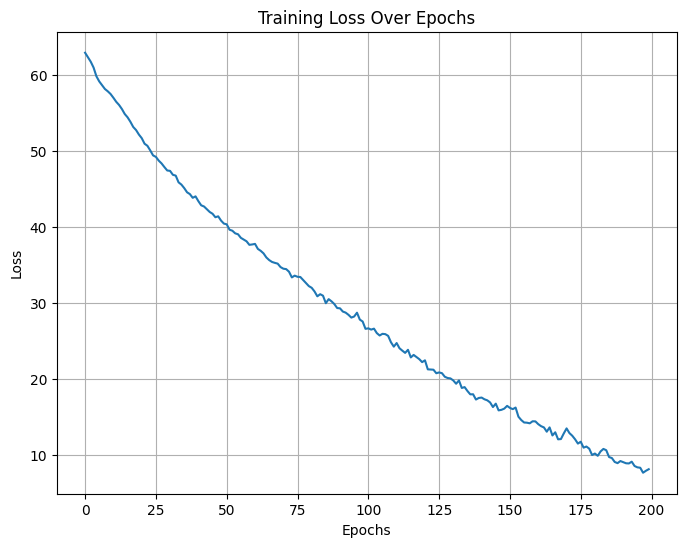

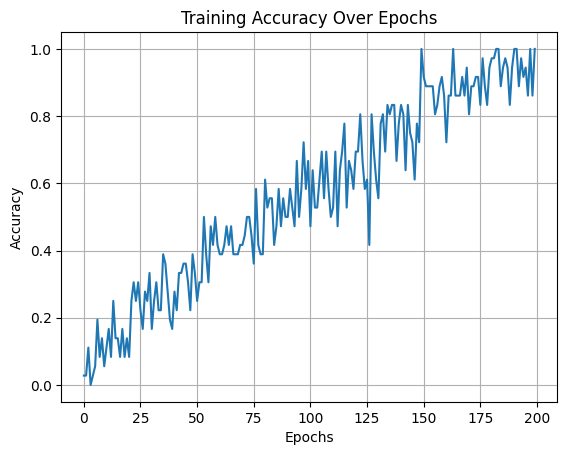

In [8]:
## plot the loss and accuracy
import matplotlib.pyplot as plt 

## plot the loss
plt.figure(figsize=(8, 6))
plt.plot(loss_all)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()


plt.plot(accuracy_all)
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

- It shows overfitting
- Need discussions 
  - Purpose of analysis
  - Types of source and target data
  - Data collection 
  - Data size

In [9]:
# Load the model
model.load_state_dict(torch.load("seq2seq_model.pth", weights_only=False))

# test the model
model.eval()
total_loss = 0
total_accuracy = 0
for batch in test_dataloader:
    src, src_len, tgt, tgt_len = batch
    src, tgt = src.to(torch.device("cpu")), tgt.to(torch.device("cpu"))

    outputs = model(src, src_len, tgt, teacher_forcing_ratio=0)
    outputs = outputs[:, 1:].reshape(-1, vocab_size)  # Skip <sos> token
    tgt = tgt[:, 1:].reshape(-1)  # Skip <sos> token in targets
    loss = criterion(outputs, tgt)
    total_loss += loss.item()

# Compute accuracy
outputs = outputs.argmax(dim=1)
correct = outputs.eq(tgt)
accuracy = correct.sum().float() / tgt.size(0)
total_accuracy += accuracy

## print the loss and accuracy
print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {total_accuracy:.4f}")

# Decode the output
def decode_output(output, idx2vocab):
    decoded_output = [idx2vocab[idx] for idx in output]
    return decoded_output

# Example usage
src, tgt = test_dataset[6]
# convert to tensor
src = torch.tensor(src).unsqueeze(0)
tgt = torch.tensor(tgt).unsqueeze(0)
src_len = [len(src)]

outputs = model(src, src_len, tgt, teacher_forcing_ratio=0)
outputs = outputs.argmax(dim=2).squeeze(0).tolist()
decoded_output = decode_output(outputs, idx2vocab)
print("Source sequence:", [idx2vocab[idx] for idx in src.squeeze(0).tolist()])
print("Target sequence:", [idx2vocab[idx] for idx in tgt.squeeze(0).tolist()])
print("Predic sequence:", decoded_output)



Test Loss: 20.1531, Test Accuracy: 0.0833
Source sequence: ['M', 'V', 'K', 'P', 'P', 'P', 'F', 'G', 'A', 'E']
Target sequence: ['M', 'V', 'K', 'P', 'P', 'P', 'F', 'G', 'T', 'E']
Predic sequence: ['A', 'P', 'N', 'C', 'E', 'H', 'C', 'G', 'L', 'R']


In [76]:
# Load the model
model.load_state_dict(torch.load("seq2seq_model.pth", weights_only=False))
model.eval()
idx = 4
# Example source sequence
example_src = torch.tensor([test_source[idx]], dtype=torch.long)
example_src_len = [len(test_source[idx])]

# Target placeholder (not used during inference)
example_tgt = torch.tensor([test_target[idx]], dtype=torch.long)

# Generate output
output = model(example_src, example_src_len, example_tgt, teacher_forcing_ratio=0)
predicted_indices = output.argmax(2).squeeze(0).tolist()

# Decode the predicted sequence
predicted_sequence = [idx2vocab[idx] for idx in predicted_indices]
print("Source Sequence:", [idx2vocab[idx] for idx in encoded_source_sequences[idx]])
print("Target Sequence:", [idx2vocab[idx] for idx in encoded_target_sequences[idx]])
print("Predicted Sequence:", predicted_sequence)


Source Sequence: ['A', 'T', 'A', 'C', 'A', 'C', 'G', 'G', 'T', 'T', 'T', 'C', 'T', 'T', 'G', 'A', 'T', 'A', 'C', 'G', 'G', 'T', 'G', 'C', 'T', 'C', 'T', 'T', 'A', 'T', 'T', 'T', 'T', 'A', 'A', 'T', 'A', 'A', 'T', 'G', 'G', 'G', 'A', 'C', 'G', 'G', 'A', 'T', 'T', 'C']
Target Sequence: ['.', '.', '.', '(', '(', '(', '.', '(', '(', '.', '.', '.', '.', '.', '.', '.', '.', ')', ')', '.', ')', ')', ')', '.', '(', '(', '(', '(', '(', '(', '(', '.', '.', '.', '.', '.', ')', ')', ')', ')', ')', ')', ')', '.', '.', '.', '.', '.', '.', '.']
Predicted Sequence: ['A', '(', '(', '(', '(', '(', '(', '(', '(', '(', '(', '(', '(', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', ')', '.', '.', '.', '.', '.', '.', '.', '.']
